## Flu Model Calibration

This tutorial walks through an example of calibrating a model of influenza transition in the US to observed weekly hospitalization numbers reported by the NHSN for the 2024-2025 influenza season using Approximate Bayesian Computation implemented in Epydemix. 

First we load the required packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy

from datetime import datetime, timedelta
import epiweeks

from scipy import stats

from epydemix import load_predefined_model, simulate, EpiModel
from epydemix.population import Population, load_epydemix_population
from epydemix.visualization import (
    plot_distance_distribution,
    plot_quantiles,
    plot_posterior_distribution,
    plot_posterior_distribution_2d,
    plot_trajectories,
    plot_contact_matrix,
    plot_population
)
from epydemix.calibration import ABCSampler, rmse
from epydemix.utils import compute_simulation_dates, convert_to_2Darray

from flumodelingsuite.seasonality import get_seasonal_transmission_balcan
from flumodelingsuite.school_closures import make_school_closure_dict, add_school_closure_interventions

import datetime as datetime

from flumodelingsuite.vaccinations import smh_data_to_epydemix, make_vaccination_probability_function, add_vaccination_schedule
from flumodelingsuite.school_closures import make_school_closure_dict, add_school_closure_interventions

Next we load the reference hospitalization data. Here we take the state of Massachusetts as an example. We consider a scenario where we only have the data that was available as of a certain date (e.g. 2025-01-01) as is the case during the forecasting season. We want to calibrate our model to this data in order to make forecasts for the next few weeks.

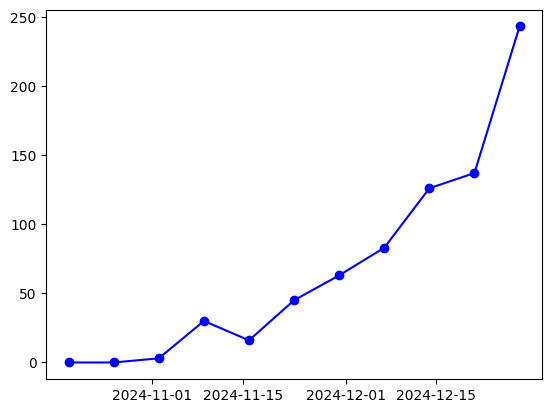

In [45]:
hosp_data = pd.read_csv("data/influenza_hosp_24.csv")
hosp_data['as_of'] = pd.to_datetime(hosp_data['as_of'])
hosp_data['issue'] = pd.to_datetime(hosp_data['issue'])
hosp_data["target_end_date"] = pd.to_datetime(hosp_data["target_end_date"])
hosp_data_ma = hosp_data[hosp_data['geo_value']=='ma']
hosp_data_ma.as_of.unique()
hosp_data_ma = hosp_data_ma[hosp_data_ma['as_of'] == '2025-01-01']
plt.plot(hosp_data_ma.target_end_date, hosp_data_ma.value, marker='o', linestyle='-', color='blue')

This code defines the model. This is a complex mechanistic model with many compartments and parameters and is summarized in the diagram below.

<img src="images/flu_model.png" width="800">


In [ ]:
def create_flu_model(date_start, date_stop):
    """ 
    """
    state_name = "Massachusetts"
    model_compartments = ["Susceptible","Susceptible_vax","Latent","Latent_vax","Infectious_symptomatic","Infectious_symptomatic_vax","Infectious_asymptomatic","Infectious_asymptomatic_vax","Home_severe","Home_severe_vax","Home_mild","Home_mild_vax","Home_asymptomatic","Home_asymptomatic_vax","Hospitalized","Hospitalized_vax","Removed_severe","Removed_severe_vax","Removed_mild","Removed_mild_vax","Removed_asymptomatic","Removed_asymptomatic_vax"]
    model = EpiModel(compartments=model_compartments)
    state_population_name = "United_States_%s" % state_name.replace(" ", "_")

    # population = load_epydemix_population(state_population_name,path_to_data="../../../../epydemix-data/")
    population = load_epydemix_population(state_population_name, age_group_mapping={
        "0-4": [str(i) for i in range(0, 5)],
        "5-17": [str(i) for i in range(5, 18)],
        "18-49": [str(i) for i in range(18, 50)],
        "50-64": [str(i) for i in range(50, 65)],
        "65+": [str(i) for i in range(65, 84)] + ["84+"]
    })
    model.set_population(population)

    #get eigen value of the contact matrix
    C = np.sum([c for _, c in model.population.contact_matrices.items()], axis=0)
    eigenvalue = np.linalg.eigvals(C).real.max()

    R0 = 1.2
    beta = R0*(1/1.5)/(eigenvalue*(1-0.45+0.45*0.5))
    parameter_dict = {
        "r_beta_asymp": 0.5,\
        "r_beta_vax": 0.7,\
        "r_vax":0.5,\
        "p_asymptomatic": 0.45,\
        "eps": 1/1.5,\
        "mu": 1/1.5,\
        "p_h": convert_to_2Darray([0.007,0.0027,0.0056,0.0110,0.0909]),\
        "mu_h":convert_to_2Darray([1/2.7, 1/3.6, 1/5.8,1/7.5,1/5.1]),\
        "delta":convert_to_2Darray([1/1.26,1/1.21,1/1.91,1/2.03,1/1.5]),\
        "eta": 1/3.5,\
        # "beta": "R0*mu/(eigen_value*(1-p_asymptomatic+p_asymptomatic*r_beta_asymp))",
        "beta": beta,
        "eigen_value": eigenvalue,
        "R0": 2.0}

    # Set model parameters
    model.add_parameter(
        parameters_dict=parameter_dict)

    closure_dict = make_school_closure_dict([2024, 2025])
    add_school_closure_interventions(model, closure_dict, 0.344)

    # Add compartment transitions
    #Infections
    model.add_transition(source="Susceptible", target="Latent", params=("beta", "Infectious_symptomatic"), kind="mediated")
    model.add_transition(source="Susceptible", target="Latent", params=("beta*r_beta_asymp", "Infectious_asymptomatic"), kind="mediated")

    model.add_transition(source="Susceptible", target="Latent", params=("beta", "Infectious_symptomatic_vax"), kind="mediated")
    model.add_transition(source="Susceptible", target="Latent", params=("beta*r_beta_asymp", "Infectious_asymptomatic_vax"), kind="mediated")
    #Transitions
    #L->I
    model.add_transition(source="Latent", target="Infectious_symptomatic", params="eps*(1-p_asymptomatic)", kind="spontaneous")  
    model.add_transition(source="Latent", target="Infectious_asymptomatic", params="eps*p_asymptomatic", kind="spontaneous")  

    #I->Home
    model.add_transition(source="Infectious_symptomatic", target="Home_severe", params="mu*p_h", kind="spontaneous")  
    model.add_transition(source="Infectious_symptomatic", target="Home_mild", params="mu*(1-p_h)", kind="spontaneous")  
    model.add_transition(source="Infectious_asymptomatic", target="Home_asymptomatic", params="mu", kind="spontaneous") 

    # Home --> Others
    model.add_transition(source="Home_severe", target="Hospitalized", params="delta", kind="spontaneous") 
    model.add_transition(source="Home_mild", target="Removed_mild", params="eta", kind="spontaneous")  
    model.add_transition(source="Home_asymptomatic", target="Removed_asymptomatic", params="eta", kind="spontaneous")  

    model.add_transition(source="Hospitalized", target="Removed_severe", params="mu_h", kind="spontaneous")



    #Build in the vaccination transitions and the vaccination branch here
    #Infections
    model.add_transition(source="Susceptible_vax", target="Latent_vax", params=("beta*r_beta_vax", "Infectious_symptomatic_vax"), kind="mediated")
    model.add_transition(source="Susceptible_vax", target="Latent_vax", params=("beta*r_beta_asymp*r_vax", "Infectious_asymptomatic_vax"), kind="mediated")

    model.add_transition(source="Susceptible_vax", target="Latent_vax", params=("beta*r_beta_vax", "Infectious_symptomatic"), kind="mediated")
    model.add_transition(source="Susceptible_vax", target="Latent_vax", params=("beta*r_beta_asymp*r_vax", "Infectious_asymptomatic"), kind="mediated")

    #Transitions
    #L->I
    model.add_transition(source="Latent_vax", target="Infectious_symptomatic_vax", params="eps*(1-p_asymptomatic)", kind="spontaneous")  
    model.add_transition(source="Latent_vax", target="Infectious_asymptomatic_vax", params="eps*p_asymptomatic", kind="spontaneous")  

    #I->Home
    model.add_transition(source="Infectious_symptomatic_vax", target="Home_severe_vax", params="mu*p_h", kind="spontaneous")  
    model.add_transition(source="Infectious_symptomatic_vax", target="Home_mild_vax", params="mu*(1-p_h)", kind="spontaneous")  
    model.add_transition(source="Infectious_asymptomatic_vax", target="Home_asymptomatic_vax", params="mu", kind="spontaneous") 

    # Home --> Others
    model.add_transition(source="Home_severe_vax", target="Hospitalized_vax", params="delta", kind="spontaneous") 
    model.add_transition(source="Home_mild_vax", target="Removed_mild_vax", params="eta", kind="spontaneous")  
    model.add_transition(source="Home_asymptomatic_vax", target="Removed_asymptomatic_vax", params="eta", kind="spontaneous")  

    model.add_transition(source="Hospitalized_vax", target="Removed_severe_vax", params="mu_h", kind="spontaneous")
    ###

    date_start = date_start
    date_stop = date_stop
    vaccination_schedule = smh_data_to_epydemix(
        input_filepath = 'data/vaccine_scenarios_2425.csv', 
        start_date=date_start, 
        end_date=date_stop, 
        model=model, 
        scenario="C_D",  
        output_filepath = None
    )
    vaccination_schedule['total_vax'] = vaccination_schedule[['0-4', '5-17', '18-49', '50-64', '65+']].sum(axis=1)

    vaccine_probability_function = make_vaccination_probability_function(
        origin_compartment="Susceptible", 
        eligible_compartments=["Susceptible", "Latent", "Infectious_asymptomatic", "Home_asymptomatic", "Removed_severe", "Removed_mild", "Removed_asymptomatic"]
    )
    # flu_model = copy.deepcopy(model)
    model = add_vaccination_schedule(
        model=model,
        vaccine_probability_function = vaccine_probability_function,
        source_comp="Susceptible",
        target_comp="Susceptible_vax",
        vaccination_schedule = vaccination_schedule
    )

    return model

This is an example of how the hospitalization numbers look for a single parameterization of the model, compared with the NHSN data. Note that there are two hospitalized compartments in this model.

Calculating closures from school calendars...

Merging school closures for total US model...

Finished iteration = 1. Progress to next iteration... 

Data reduction succesful! Stopped at iteration 2

Adding state and national holidays...

School closures computed.

School closure interventions added to model for United_States_Massachusetts



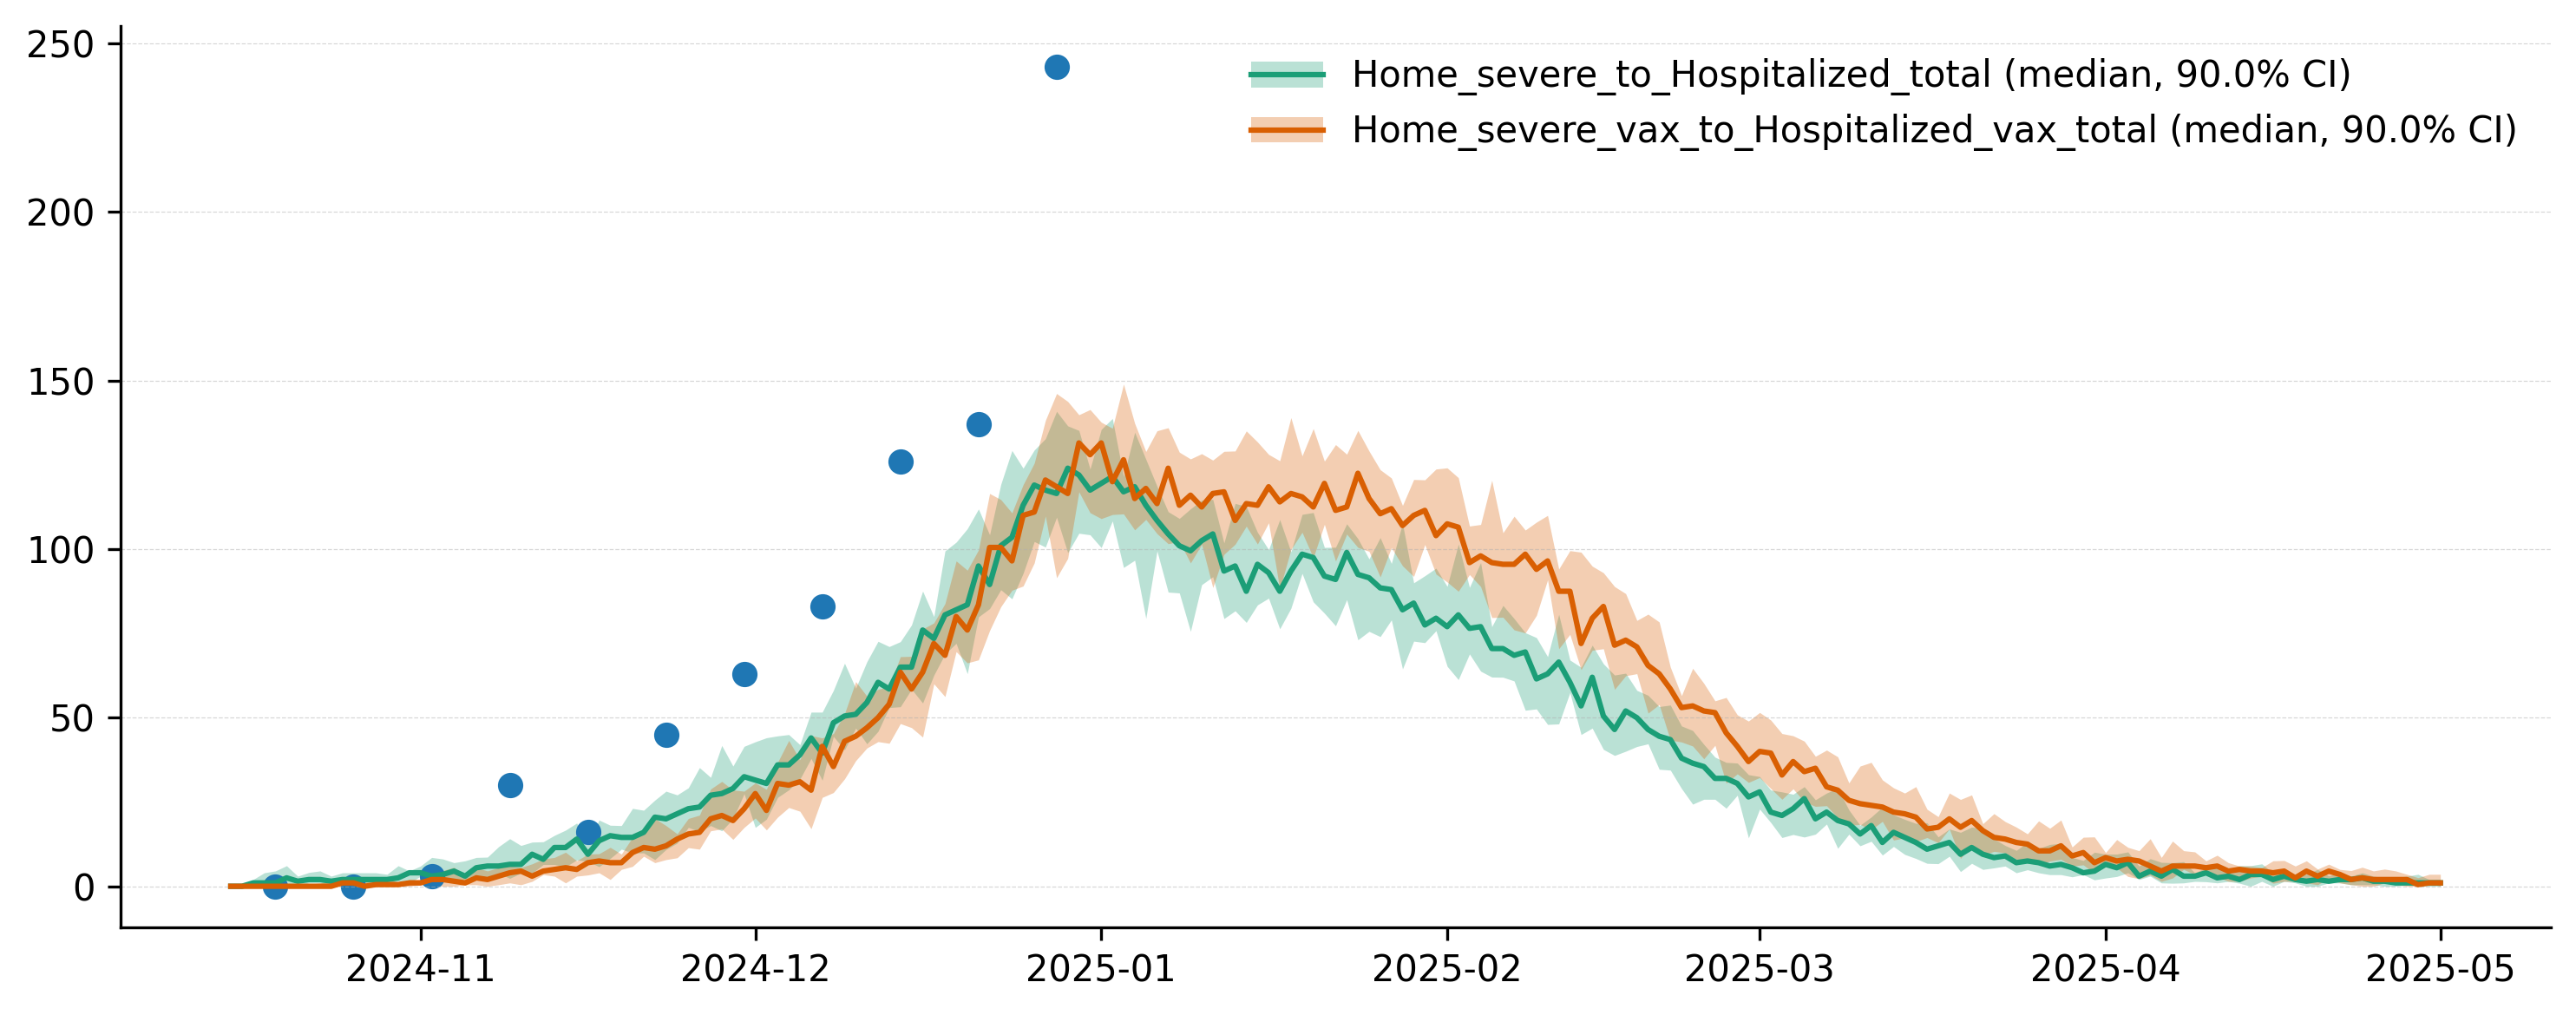

In [46]:
date_start = datetime.date(2024, 10, 15)
date_stop = datetime.date(2025, 5, 1)

model = create_flu_model(
    date_start=date_start, 
    date_stop=date_stop)

np.random.seed(19)
results = model.run_simulations(
    start_date=date_start, 
    end_date=date_stop, 
    # percentage_in_agents=10/model.population.Nk.sum(),
    initial_conditions_dict={
        "Susceptible": (0.9999 * model.population.Nk),
        "Latent": (0.0001 * model.population.Nk),
        "Susceptible_vax": (0.0 * model.population.Nk),}, 
    Nsim=10
)
# df_quantiles = results.get_quantiles_compartments()
# ax = plot_quantiles(df_quantiles, columns=["Susceptible_total", "Latent_total", "Susceptible_vax_total", "Latent_vax_total", "Hospitalized_total", "Hospitalized_vax_total"], legend_loc="best")
df_trans = results.get_quantiles_transitions()
ax = plot_quantiles(df_trans, columns=["Home_severe_to_Hospitalized_total", "Home_severe_vax_to_Hospitalized_vax_total"], legend_loc="best")
ax.scatter(hosp_data_ma['target_end_date'], hosp_data_ma['value'])

In [5]:
from scipy import stats 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from epydemix import load_predefined_model, simulate
from epydemix.visualization import plot_distance_distribution, plot_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d
from epydemix.calibration import ABCSampler, rmse 
from epydemix.utils import compute_simulation_dates

In [6]:
def reaggregate_vaccines(schedule, actual_start_date):
    """
    Reaggregate the vaccination schedule to start from the actual start date.
    """
    start_date = schedule['dates'].min()
    if pd.Timestamp(actual_start_date) < start_date:
        raise ValueError("Actual start date cannot be earlier than the earliest date in the vaccine schedule")

    actual_start_date = actual_start_date
    days_until_saturday = 5 - actual_start_date.weekday()
    if days_until_saturday < 0:
        days_until_saturday += 7

    # inclusive
    next_saturday = actual_start_date + datetime.timedelta(days=days_until_saturday)
    days_between_inclusive = days_until_saturday + 1

    age_groups = ["0-4", "5-17", "18-49", "50-64", "65+"]
    aggregated_doses = schedule.query("dates < @next_saturday")[age_groups].sum(axis=0)

    daily_doses = round(aggregated_doses / days_between_inclusive)

    rows = []
    scen = vaccination_schedule_ma.scenario.unique()[0]
    current_date = actual_start_date
    while current_date <= next_saturday:
        # print(current_date)
        rows.append({
            "dates": pd.Timestamp(current_date),
            "location": "US-MA",
            "scenario": scen,
            "0-4": daily_doses["0-4"],
            "5-17": daily_doses["5-17"],
            "18-49": daily_doses["18-49"],
            "50-64": daily_doses["50-64"],
            "65+": daily_doses["65+"],
        })
        current_date += datetime.timedelta(days=1)

    filtered_schedule = schedule.query("dates > @next_saturday")
    reaggregated_schedule = pd.concat([filtered_schedule, pd.DataFrame(rows)], ignore_index=True).sort_values(by="dates")
    reaggregated_schedule["total_vax"] = reaggregated_schedule[["0-4", "5-17", "18-49", "50-64", "65+"]].sum(axis=1)

    return reaggregated_schedule

In [11]:
# Attempting to pull vaccine processing outside the wrapper
initial_conditions = {
    "Susceptible": (0.9999 * model.population.Nk),
    "Latent": (0.0001 * model.population.Nk),
    "Susceptible_vax": (0.0 * model.population.Nk),
}

reference_date = datetime.date(2024, 9, 13)  # epiweek 42 start date

vaccination_schedule = smh_data_to_epydemix(
    input_filepath = 'data/vaccine_scenarios_2425.csv', 
    start_date=reference_date, 
    end_date=date_stop, 
    model=model,  # Use the renamed variable
    scenario="C_D",  
    output_filepath = None
)
vaccination_schedule['total_vax'] = vaccination_schedule[['0-4', '5-17', '18-49', '50-64', '65+']].sum(axis=1)
vaccination_schedule_ma = vaccination_schedule[vaccination_schedule['location']=='US-MA']

# Base parameters (without start_date since it will come from the prior)
parameters = {
    "initial_conditions_dict": initial_conditions,
    "epimodel": model,
    "end_date": date_stop,
    # "vaccination_schedule": vaccination_schedule_ma,  
    "resample_frequency": "W-SAT"
}

priors = {
    "beta": stats.uniform(0.010, 0.200),
    'start_date_offset': stats.randint(low=0, high=30) 
}

def simulate_wrapper(params):
    # Extract the sampled parameters
    beta = params['beta']
    date_stop = params['end_date']
    start_date_offset = int(params['start_date_offset'])
    
    # Calculate the actual start date using the offset (in weeks)
    actual_start_date = reference_date + datetime.timedelta(days=start_date_offset)
    
    # Get the model from params and update beta
    epi_model = params['epimodel']  # Use a different variable name
    epi_model.beta = beta
    
    ### Recreate vaccination schedule with the new start date

    # vaccination_schedule_ma = params['vaccination_schedule']  
    vaxi_schedule = reaggregate_vaccines(
        schedule=vaccination_schedule_ma, 
        actual_start_date=actual_start_date
    )

    # print(actual_start_date)
    # print(vaxi_schedule.dates.min())
    # print(date_stop)
    # print(vaxi_schedule.dates.max())

    vaccine_probability_function = make_vaccination_probability_function(
        origin_compartment="Susceptible", 
        eligible_compartments=["Susceptible", "Latent", "Infectious_asymptomatic", 
                              "Home_asymptomatic", "Removed_severe", "Removed_mild", 
                              "Removed_asymptomatic"]
    )

    # Update the model with vaccination schedule
    epi_model = add_vaccination_schedule(
        model=epi_model,  # Use the renamed variable
        vaccine_probability_function = vaccine_probability_function,
        source_comp="Susceptible",
        target_comp="Susceptible_vax",
        vaccination_schedule = vaxi_schedule
    )
    
    # Create simulation parameters with the calculated start_date and updated model
    sim_params = {
        **params,
        'epimodel': epi_model,  # Use the updated model
        'start_date': actual_start_date
    }
    
    # Run simulation
    results = simulate(**sim_params)
    
    # Extract hospitalizations
    total_hosp = results.transitions["Home_severe_to_Hospitalized_total"] + \
                 results.transitions["Home_severe_vax_to_Hospitalized_vax_total"]
    
    # Calculate indices based on the actual start date used
    start_index = (pd.to_datetime(hosp_data_ma.target_end_date.values[0]) - 
                   pd.to_datetime(actual_start_date)).days // 7
    end_index = len(hosp_data_ma.value.values) + start_index
    
    total_hosp = total_hosp[start_index:end_index]
    
    return {"data": total_hosp}

abc_sampler = ABCSampler(
    simulation_function=simulate_wrapper, 
    priors=priors, 
    parameters=parameters, 
    observed_data=hosp_data_ma["value"].values, 
    distance_function=rmse
)


In [ ]:
results_abc_top = abc_sampler.calibrate(strategy="top_fraction", top_fraction = 0.05, Nsim=1000)

Starting ABC top fraction selection with 1000 simulations and top 5.0% selected
	Selected 50 particles (top 5.0%) with distance threshold 95.397136


In [18]:
results_abc_smc = abc_sampler.calibrate(strategy="smc", num_particles=20, num_generations=10)

Starting ABC-SMC with 20 particles and 10 generations

Generation 1/10 (epsilon: inf)
	Accepted 20/20 (acceptance rate: 100.00%)
	Elapsed time: 00:00:05

Generation 2/10 (epsilon: 9551.282073)
	Accepted 20/42 (acceptance rate: 47.62%)
	Elapsed time: 00:00:11

Generation 3/10 (epsilon: 1443.189415)
	Accepted 20/42 (acceptance rate: 47.62%)
	Elapsed time: 00:00:12

Generation 4/10 (epsilon: 101.904144)
	Accepted 20/53 (acceptance rate: 37.74%)
	Elapsed time: 00:00:17

Generation 5/10 (epsilon: 95.449245)
	Accepted 20/103 (acceptance rate: 19.42%)
	Elapsed time: 00:00:34

Generation 6/10 (epsilon: 80.936246)
	Accepted 20/72 (acceptance rate: 27.78%)
	Elapsed time: 00:00:27

Generation 7/10 (epsilon: 58.731413)
	Accepted 20/92 (acceptance rate: 21.74%)
	Elapsed time: 00:00:38

Generation 8/10 (epsilon: 48.238841)
	Accepted 20/74 (acceptance rate: 27.03%)
	Elapsed time: 00:00:30

Generation 9/10 (epsilon: 37.235225)
	Accepted 20/226 (acceptance rate: 8.85%)
	Elapsed time: 00:01:33

Generati

In [63]:
hosp_data_ma

,as_of,geo_value,signal,source,time_type,time_value,issue,value,target_end_date,data
9558,2025-01-01,ma,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-10-13,2024-12-29,0.0,2024-10-19,0.0
9559,2025-01-01,ma,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-10-20,2024-12-29,0.0,2024-10-26,0.0
9560,2025-01-01,ma,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-10-27,2024-12-29,3.0,2024-11-02,3.0
9561,2025-01-01,ma,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-11-03,2024-12-29,30.0,2024-11-09,30.0
9562,2025-01-01,ma,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-11-10,2024-12-29,16.0,2024-11-16,16.0
9563,2025-01-01,ma,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-11-17,2024-12-29,45.0,2024-11-23,45.0
9564,2025-01-01,ma,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-11-24,2024-12-29,63.0,2024-11-30,63.0
9565,2025-01-01,ma,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-12-01,2024-12-29,83.0,2024-12-07,83.0
9566,2025-01-01,ma,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-12-08,2024-12-29,126.0,2024-12-14,126.0
9567,2025-01-01,ma,confirmed_admissions_flu_ew_prelim,nhsn,week,2024-12-15,2024-12-29,137.0,2024-12-21,137.0


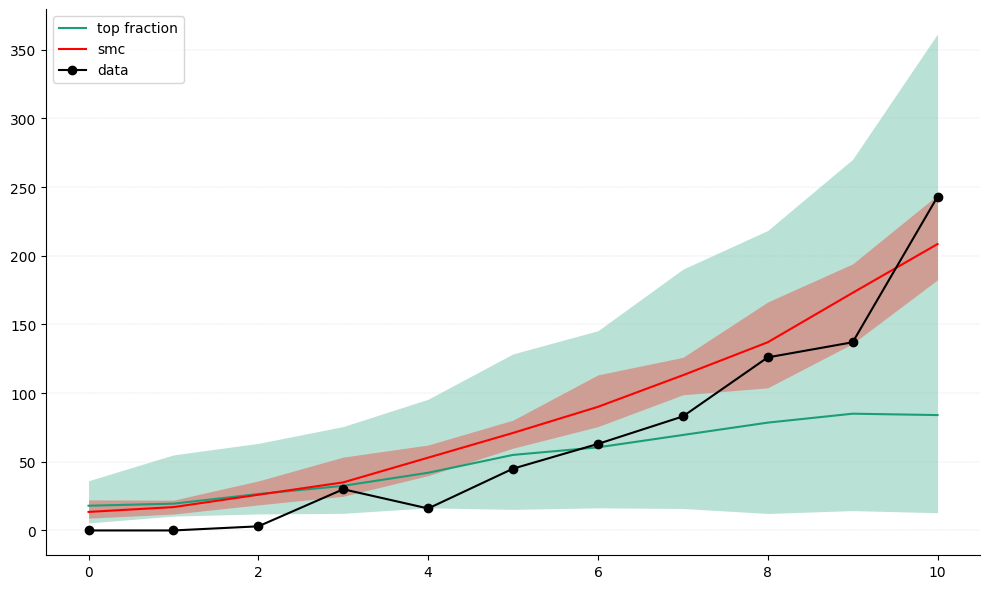

In [68]:
df_quantiles_abc_top = results_abc_top.get_calibration_quantiles()
df_quantiles_abc_smc = results_abc_smc.get_calibration_quantiles()
hosp_data_ma["data"] = hosp_data_ma["value"]
fig, ax = plt.subplots(figsize=(10, 6))
plot_quantiles(df_quantiles_abc_top, columns="data", labels = ["top fraction"], ax=ax)
plot_quantiles(df_quantiles_abc_smc, columns="data", colors=["red"], labels =["smc"], ax=ax)
plt.plot(range(0,len(hosp_data_ma)), hosp_data_ma['value'], marker='o', linestyle='-', color='black', label="data")
ax.legend()

Text(0.5, 1.0, 'Top Fraction')

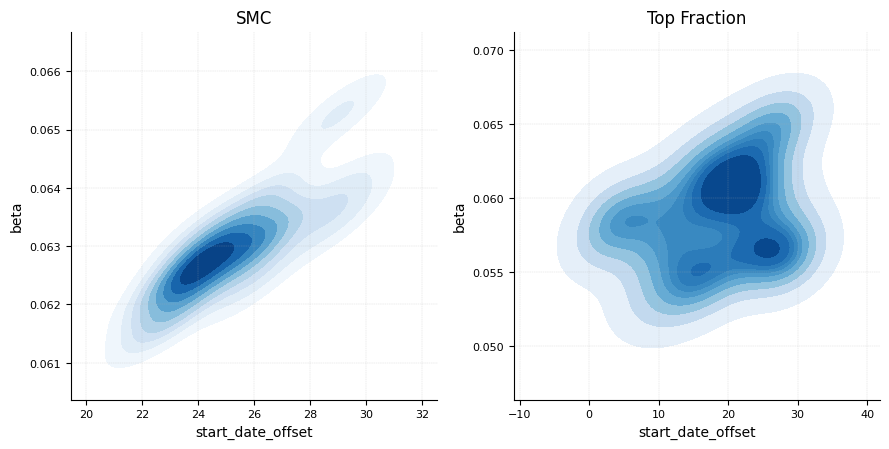

In [ ]:
df_posterior = results_abc_smc.get_posterior_distribution()
fig, ax = plt.subplots(1,2, figsize=(9, 5))
plot_posterior_distribution_2d(df_posterior, "start_date_offset", "beta", kind="kde", ax = ax[0])
ax[0].set_title("SMC")

df_posterior_top = results_abc_top.get_posterior_distribution()
plot_posterior_distribution_2d(df_posterior_top, "start_date_offset", "beta", kind="kde", ax = ax[1])
ax[1].set_title("Top Fraction")

Text(0.5, 1.0, 'Top Fraction')

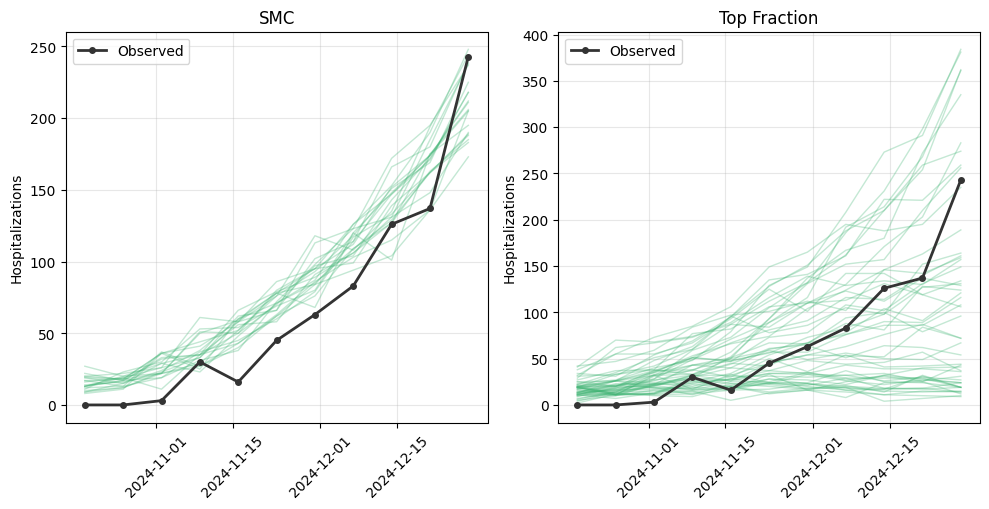

In [ ]:
def plot_individual_trajectories(results, hosp_data_ma, reference_date, ax=ax, generation=None, max_trajectories=100):
    """Plot individual trajectories from ABC results with proper date alignment."""
    
    # Get trajectories and posterior samples
    trajectories = results.get_selected_trajectories(generation)
    posterior = results.get_posterior_distribution(generation)
    
    # Set up the figure
    # fig, ax = plt.subplots(figsize=(7, 6))
    
    # Get observed data dates
    obs_dates = pd.to_datetime(hosp_data_ma.target_end_date.values)
    
    # Plot each trajectory
    for i, (traj, params) in enumerate(zip(trajectories[:max_trajectories], 
                                           posterior.iloc[:max_trajectories].iterrows())):
        # Get the start date offset for this trajectory
        start_offset = int(params[1]['start_date_offset'])
        # print(start_offset)
        sim_start_date = reference_date + pd.Timedelta(days=start_offset)
        
        # Get the simulation data
        sim_data = traj['data']
        
        # Create date range for this simulation
        sim_dates = pd.date_range(start=sim_start_date, periods=len(sim_data), freq='W-SAT')
        
        # Plot with transparency
        ax.plot(obs_dates, sim_data, alpha=0.3, color='mediumseagreen', linewidth=1)
    
    # Plot observed data on top
    ax.plot(obs_dates, hosp_data_ma['value'].values, 'o-', color = ".2", label='Observed', 
            markersize=4, linewidth=2)
    
    ax.set_ylabel('Hospitalizations')
    # ax.set_title(f'Individual Trajectories (n={min(max_trajectories, len(trajectories))})')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()

fig, ax = plt.subplots(1,2, figsize=(10, 5))
plot_individual_trajectories(results_abc_smc, hosp_data_ma, reference_date, ax=ax[0], max_trajectories=50)
plot_individual_trajectories(results_abc_top, hosp_data_ma, reference_date, ax=ax[1], max_trajectories=50)
ax[0].set_title("SMC")
ax[1].set_title("Top Fraction")
